# 导入必要的库

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

from utils import *
from models import *

import numpy as np

from tqdm import tqdm
import random

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 载入风格图像

(391, 470, 3)


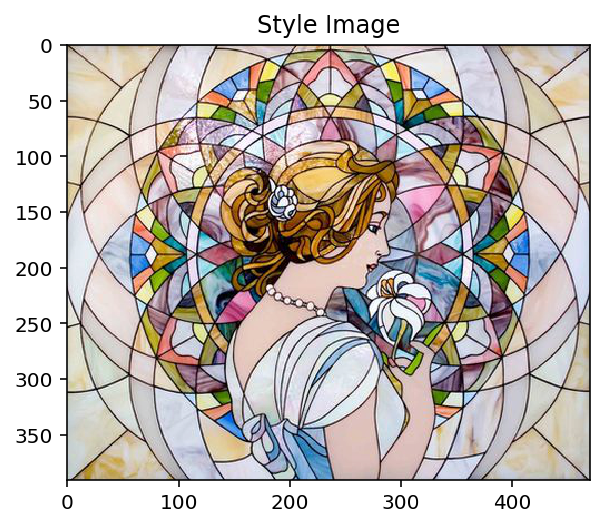

In [2]:
style_path = "images/mosaic.jpg"
style_img = read_image(style_path).to(device)
imshow(style_img, title='Style Image')

# 搭建自定义 VGG16 模型



## 提取部分特征

* https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py
* https://arxiv.org/abs/1603.08155

特征为 VGG16 的 relu_1_2、relu_2_2、relu_3_3 和 relu_4_3。

![image.png](attachment:image.png)

In [3]:
vgg16 = models.vgg16(pretrained=True)
vgg16 = VGG(vgg16.features[:23]).to(device).eval()

# 搭建转换网络

* https://github.com/pytorch/examples/blob/0.4/fast_neural_style/neural_style/transformer_net.py#L57-L76
* https://github.com/pytorch/examples/blob/0.4/fast_neural_style/neural_style/transformer_net.py#L79-L101
* http://torch.ch/blog/2016/02/04/resnets.html
* https://cs.stanford.edu/people/jcjohns/papers/fast-style/fast-style-supp.pdf

![image.png](attachment:image.png)

In [4]:
def ConvLayer(in_channels, out_channels, kernel_size=3, stride=1, 
    upsample=None, instance_norm=True, relu=True):
    layers = []
    if upsample:
        layers.append(nn.Upsample(mode='nearest', scale_factor=upsample))
    layers.append(nn.ReflectionPad2d(kernel_size // 2))
    layers.append(nn.Conv2d(in_channels, out_channels, kernel_size, stride))
    if instance_norm:
        layers.append(nn.InstanceNorm2d(out_channels))
    if relu:
        layers.append(nn.ReLU())
    return layers

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv = nn.Sequential(
            *ConvLayer(channels, channels, kernel_size=3, stride=1), 
            *ConvLayer(channels, channels, kernel_size=3, stride=1, relu=False)
        )

    def forward(self, x):
        return self.conv(x) + x

In [5]:
class TransformNet(nn.Module):
    def __init__(self, base=32):
        super(TransformNet, self).__init__()
        self.downsampling = nn.Sequential(
            *ConvLayer(3, base, kernel_size=9), 
            *ConvLayer(base, base*2, kernel_size=3, stride=2), 
            *ConvLayer(base*2, base*4, kernel_size=3, stride=2), 
        )
        self.residuals = nn.Sequential(*[ResidualBlock(base*4) for i in range(5)])
        self.upsampling = nn.Sequential(
            *ConvLayer(base*4, base*2, kernel_size=3, upsample=2),
            *ConvLayer(base*2, base, kernel_size=3, upsample=2),
            *ConvLayer(base, 3, kernel_size=9, instance_norm=False, relu=False),
        )
    
    def forward(self, X):
        y = self.downsampling(X)
        y = self.residuals(y)
        y = self.upsampling(y)
        return y

## Gram 矩阵函数

In [6]:
def gram_matrix(y):
    (b, ch, h, w) = y.size()
    features = y.view(b, ch, w * h)
    features_t = features.transpose(1, 2)
    gram = features.bmm(features_t) / (ch * h * w)
    return gram

# 训练模型

## 载入 COCO 数据集

In [7]:
!rm -rf /home/ypw/COCO/*/.AppleDouble

batch_size = 4
width = 256

data_transform = transforms.Compose([
    transforms.Resize(width), 
    transforms.CenterCrop(width), 
    transforms.ToTensor(), 
    tensor_normalizer, 
])

dataset = torchvision.datasets.ImageFolder('/home/ypw/COCO/', transform=data_transform)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
dataset

Dataset ImageFolder
    Number of datapoints: 164062
    Root Location: /home/ypw/COCO/
    Transforms (if any): Compose(
                             Resize(size=256, interpolation=PIL.Image.BILINEAR)
                             CenterCrop(size=(256, 256))
                             ToTensor()
                             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                         )
    Target Transforms (if any): None

## 计算风格图像的 Gram 矩阵

In [8]:
style_features = vgg16(style_img)
style_grams = [gram_matrix(x) for x in style_features]
style_grams = [x.detach() for x in style_grams]
[x.shape for x in style_grams]

[torch.Size([1, 64, 64]),
 torch.Size([1, 128, 128]),
 torch.Size([1, 256, 256]),
 torch.Size([1, 512, 512])]

## 开始训练

https://github.com/jcjohnson/fast-neural-style/blob/master/doc/training.md

In [10]:
%mkdir -p debug

def tensor_to_array(tensor):
    x = tensor.cpu().detach().numpy()
    x = (x*255).clip(0, 255).transpose(0, 2, 3, 1).astype(np.uint8)
    return x

def save_debug_image(style_images, content_images, transformed_images, filename):
    style_image = Image.fromarray(recover_image(style_images))
    content_images = [recover_image(x) for x in content_images]
    transformed_images = [recover_image(x) for x in transformed_images]
    
    new_im = Image.new('RGB', (style_image.size[0] + (width + 5) * 4, max(style_image.size[1], width*2 + 5)))
    new_im.paste(style_image, (0,0))
    
    x = style_image.size[0] + 5
    for i, (a, b) in enumerate(zip(content_images, transformed_images)):
        new_im.paste(Image.fromarray(a), (x + (width + 5) * i, 0))
        new_im.paste(Image.fromarray(b), (x + (width + 5) * i, width + 5))
    
    new_im.save(filename)

In [11]:
transform_net = TransformNet(32).to(device)

In [12]:
verbose_batch = 800
style_weight = 1e5
content_weight = 1
tv_weight = 1e-6

optimizer = optim.Adam(transform_net.parameters(), 1e-3)
transform_net.train()

n_batch = len(data_loader)

for epoch in range(1):
    print('Epoch: {}'.format(epoch+1))
    smooth_content_loss = Smooth()
    smooth_style_loss = Smooth()
    smooth_tv_loss = Smooth()
    smooth_loss = Smooth()
    with tqdm(enumerate(data_loader), total=n_batch) as pbar:
        for batch, (content_images, _) in pbar:
            optimizer.zero_grad()

            # 使用风格模型预测风格迁移图像
            content_images = content_images.to(device)
            transformed_images = transform_net(content_images)
            transformed_images = transformed_images.clamp(-3, 3)

            # 使用 vgg16 计算特征
            content_features = vgg16(content_images)
            transformed_features = vgg16(transformed_images)

            # content loss
            content_loss = content_weight * F.mse_loss(transformed_features[1], content_features[1])
            
            # total variation loss
            y = transformed_images
            tv_loss = tv_weight * (torch.sum(torch.abs(y[:, :, :, :-1] - y[:, :, :, 1:])) + 
            torch.sum(torch.abs(y[:, :, :-1, :] - y[:, :, 1:, :])))

            # style loss
            style_loss = 0.
            transformed_grams = [gram_matrix(x) for x in transformed_features]
            for transformed_gram, style_gram in zip(transformed_grams, style_grams):
                style_loss += style_weight * F.mse_loss(transformed_gram, 
                                                        style_gram.expand_as(transformed_gram))

            # 加起来
            loss = style_loss + content_loss + tv_loss

            loss.backward()
            optimizer.step()

            smooth_content_loss += content_loss.item()
            smooth_style_loss += style_loss.item()
            smooth_tv_loss += tv_loss.item()
            smooth_loss += loss.item()
            
            s = f'Content: {smooth_content_loss:.2f} '
            s += f'Style: {smooth_style_loss:.2f} '
            s += f'TV: {smooth_tv_loss:.4f} '
            s += f'Loss: {smooth_loss:.2f}'
            if batch % verbose_batch == 0:
                s = '\n' + s
                save_debug_image(style_img, content_images, transformed_images, 
                                 f"debug/s2_{epoch}_{batch}.jpg")
            
            pbar.set_description(s)
    torch.save(transform_net.state_dict(), 'transform_net.pth')

  0%|          | 0/41016 [00:00<?, ?it/s]

Epoch: 1



Content: 10.56 Style: 191.39 TV: 0.2717 Loss: 202.22:   0%|          | 0/41016 [00:00<?, ?it/s]
Content: 14.95 Style: 5.64 TV: 0.6129 Loss: 21.20:   2%|▏         | 800/41016 [02:18<1:55:45,  5.79it/s]  
Content: 15.02 Style: 5.55 TV: 0.6136 Loss: 21.18:   2%|▏         | 800/41016 [02:18<1:55:56,  5.78it/s]
Content: 13.14 Style: 4.49 TV: 0.6067 Loss: 18.24:   4%|▍         | 1600/41016 [04:32<1:51:52,  5.87it/s]
Content: 13.16 Style: 4.52 TV: 0.6075 Loss: 18.29:   4%|▍         | 1600/41016 [04:32<1:51:57,  5.87it/s]
Content: 12.81 Style: 5.07 TV: 0.5829 Loss: 18.46:   6%|▌         | 2400/41016 [06:48<1:49:37,  5.87it/s] 
Content: 12.79 Style: 5.09 TV: 0.5839 Loss: 18.47:   6%|▌         | 2400/41016 [06:49<1:49:41,  5.87it/s]
Content: 12.13 Style: 5.27 TV: 0.5892 Loss: 17.99:   8%|▊         | 3200/41016 [09:05<1:47:23,  5.87it/s] 
Content: 12.09 Style: 5.29 TV: 0.5885 Loss: 17.97:   8%|▊         | 3200/41016 [09:05<1:47:26,  5.87it/s]
Content: 11.97 Style: 3.84 TV: 0.5975 Loss: 16.41:  1

# 可视化风格图片

(391, 470, 3)
(256, 256, 3)
(256, 256, 3)


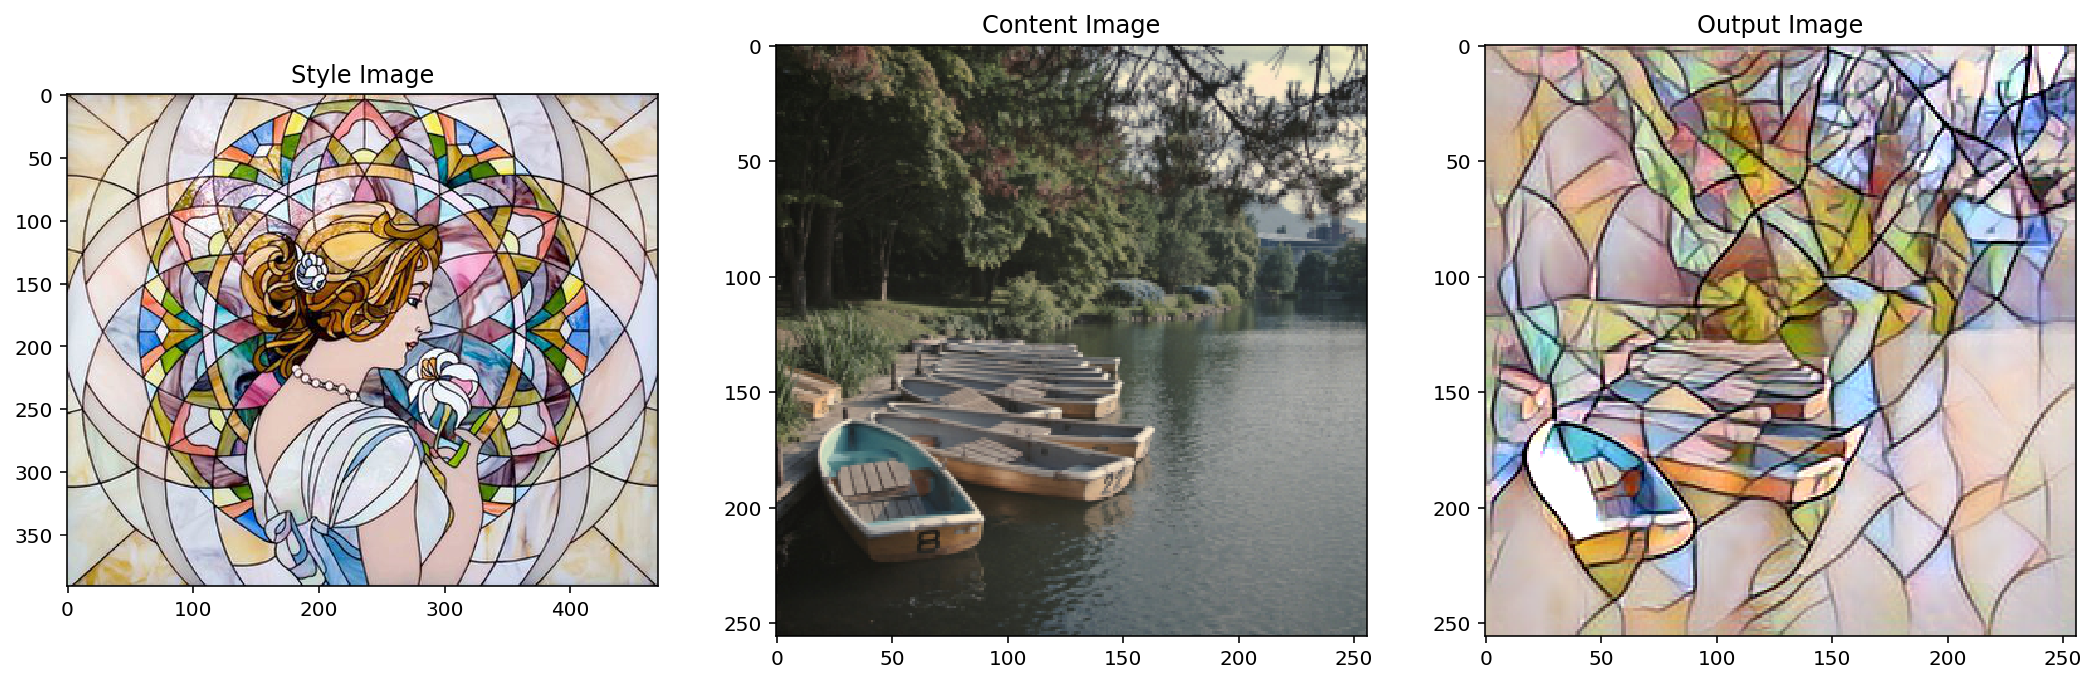

In [13]:
content_img = random.choice(dataset)[0].unsqueeze(0).to(device)
output_img = transform_net(content_img)

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
imshow(style_img, title='Style Image')

plt.subplot(1, 3, 2)
imshow(content_img, title='Content Image')

plt.subplot(1, 3, 3)
imshow(output_img.detach(), title='Output Image')